# PDP Assignment #3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame
from mpl_toolkits.axes_grid1 import make_axes_locatable
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

---

## Instructions
Train a 3-layer (input, hidden, output) network to classify hand written digits (3 and 5) from the MNIST dataset. Once you set up and trained the network you can choose do either of two things: 

(a) Investigate the performance of the network as a function of the number of hidden units. Make some nice plots. You may also want to investigate other network parameters (e.g. learning rate, simulated annealing). Provide potential explanations for the effects you observe. 

(b) Investigate the hidden layer representations (activation values of hidden units) for input patterns that represent the digits 3 vs. digits 5. This requires reasonable performance of the network. You may also want to investigate how these representations change with learning, e.g., does the average hidden representation for digit 3 become less similar to the average hidden representation for digit 5? Explain what you observe. 

You only have to do either (a) or (b) but you are welcome to complete both exercises.

---

## Summary
In this assignment, I investigate the representations learned by uniformly-connected, logistic-thresholded neural networks during digit classification with the MNIST dataset. I first address classifying digits 3 and 5 before moving onto the challenge of classifying all digits 0-9. I argue that, in the first case, only impoverished representations are needed to achieve high out-of-sample classification performance. I then show that richer, [combinatorial representations](https://distill.pub/2018/building-blocks/) emerge from learning on all digits.

### Network Architecture

In the exercises below, I train a series of neural networks that share the same architectural properties:

1. **One hidden layer:** The networks below will utilize only one hidden layer.

2. **Uniform connections:** units between layers are uniformly connected (i.e. all-to-all).

3. **Logistic activation:** the non-linear logistic transform is applied to the the activation of the hidden units.

4. **Softmax decision:** the activation of the the output layer is passed to the softmax transform to generate a decision per image. 

5. **Stochastic gradient descent:** similar to the PDP software, the network is trained using stochastic gradient descent.

### MNIST Dataset
The [MNSIT dataset](https://en.wikipedia.org/wiki/MNIST_database) is a large database of handwritten digits (over 70,000 images total). The black-and-white images have been normalized to fit into a 28x28 pixel bounding box. The challenge of the MNIST dataset is to train a machine learning model that can accurately classify the digit class (0-9) from an example image.

We load the data below. For the sake of this exercise, we will only use 1000 example images per digit. To give an idea of the data we are looking at, we will plot a composite image of each digit 0-9. (Each image is the average all image examples within a digit class.) 

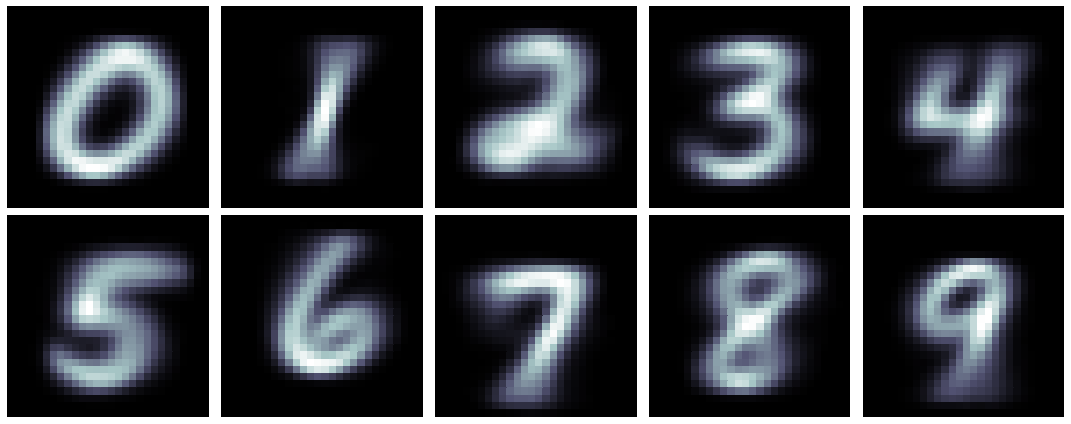

In [2]:
from sklearn.datasets import fetch_mldata

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Fetch MNIST dataset.
mnist = fetch_mldata("MNIST original")

## Extract data.
data = mnist['data'] / 255
target = mnist['target']

## Restrict dataset.
n_samples = 1000
ix = np.concatenate([np.where(target==i)[0][:n_samples] for i in np.unique(target)])
data = data[ix]
target = target[ix]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(2,5,figsize=(15,6))

for i, ax in enumerate(axes.flatten()):
    
    ## Compute mean image.
    avg_img = data[target==i].mean(axis=0)
    
    ## Plot image.
    sns.heatmap(avg_img.reshape(28,28), cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[])
    
plt.tight_layout()

## Part 1: Classifying 3s and 5s

### a) The Challenge

Before training any neural network model, let's first reframe the challenge of classifying the digits 3 and 5. Imagine the following scenario: You are participating in an experiment in which you have been instructed to learn a Braille-like tactile writing system. In this writing system, the Arabic digits have been transcribed (with high fidelity) onto a 2d surface where raised bumps indicate the contours of the digit. You are blindfolded and can only use your hands to inspect the surface. In such a scenario, how would you discriminate between the digits 3 and 5?

A simple solution is to compare the relative distribution of bumps along the 2d surface. Consider the shapes of the digits 3 and 5. Roughly speaking, the Arabic digit 3 is two vertically stacked half-circles with their "spines" aligned to the left. In contrast, the Arabic digit 5 is essentially two vertically stacked half-circles where the bottom and top half-circles are right- and left-aligned, respectively. As such the digits 3 and 5 are approximately similar in shape in comparing their bottom halves. The bottom half of any example 2d surface thus carries little information for the purposes of discriminating between 3s and 5s. The top halves of the two digits, however, differ in shape and thus provide discriminatory information. A useful strategy then for accurately discriminating between 3s and 5s along the 2d tactile surface would be to ignore the bottom half of any surface and instead inspect the relative distribution of "bumps" along the top half.

To summarize, in discriminating between 3s and 5s we should identify and focus on those regions in space that differ between the two images. With the MNIST dataset, it is very easy to find those regions where the relative distributions of (bright) pixels, as opposed to tactile bumps, differ. We can simply subtract an average of all 3s from an average of all 5s.

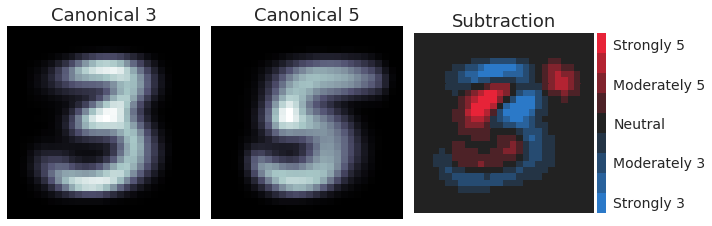

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Reduce to first 1000 3s and 5s.
ix = np.in1d(target, [3,5])
X = data[ix]
Y = target[ix]

## Make average 3 & 5 image.
average_3_img = data[target==3].mean(axis=0).reshape(28,28)
average_5_img = data[target==5].mean(axis=0).reshape(28,28)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(10,10/3))

## Plot average images.
for ax, img, title in zip(axes, [average_3_img, average_5_img], [3,5]):
    sns.heatmap(img, cmap='bone', square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Canonical %s' %title)

## Plot subtraction.
cmap = sns.diverging_palette(250, 10, s=90, l=50, n=9, center="dark")
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sub_img = average_5_img-average_3_img
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='Subtraction')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);

plt.tight_layout()

As can plainly be observed, the subtraction reveals those pixels that are representative of the digit 5 (red), representative of the digit 3 (blue), and those that are uninformative (black). This suggests that if we wanted to build software that discriminates between 3s and 5s, we could probably achieve decent classification performance by programming the software to look only at the informative (i.e. red/blue) pixels above and to make a decision based on the the extent to which bright pixels overlapped with the red or blue pixels. We can call this approach this strategy the "relative differences" algorithm. 

There are two important features of this hypothetical strategy. First, it is blind to spatial dependencies. The "relative differences algorithm is insensitive to the fact that, given a digit, pixels tend to regularly co-occur. In other words, it never learns that digits are comprised of shapes (half-circles, straight lines, etc.); it only learns that specific individual pixels are usually bright when a 3 or 5 is present. We could scramble the pixels of all the 3s or 5s and the algorithm would perform equally well insofar that the new pixel locations were constant across all images. Second and relatedly, the algorithm is sensitive only to relative differences. The algorithm does not learn the shape of the digits 3 or 5, only where these shapes differ (remember that the algorithm ignores uninformative pixels).

Clearly, the "representations" that the relative differences algorithm can learn are impoverished at best. To reiterate the algorithm learns only the discriminatory value of individual pixels, not the spatial distribution of pixels that comprise a digit's shape. We show below that, in the context of discriminating the digits 3 and 5, these impoverished representations are what a uniformly-connected neural network learns. 

### b) Logistic Regression Classifier
To demonstrate that a neural network will learn impoverished representations, we will compare it to a logistic regression classifier. The logistic regression classifier is equivalent to a neural network with no hidden layer: Each input unit is connected to a single output unit via set of weights. A logistic function is applied to the output unit to scale the output activation (i.e. decision) between 0 and 1, corresponding to the digits 3 and 5 respectively. In this model, positive weights denote pixels that are on-average predictive of the digit 5; negative weights denote pixels that are on-average predictive of the digit 3; and weights near zero are on-average unpredictive. 

We choose the logistic regression classifier because its properties match those of the relative differences algorithm: namely, it is insensitive to spatial dependencies (i.e. weights are independent) and it learns only relative differences.    

Below we train and test several variants of the logistic regression classifier at varying levels of regularization ($\alpha$). We select for inspection the variant whose regularization-level maximizes performance. 

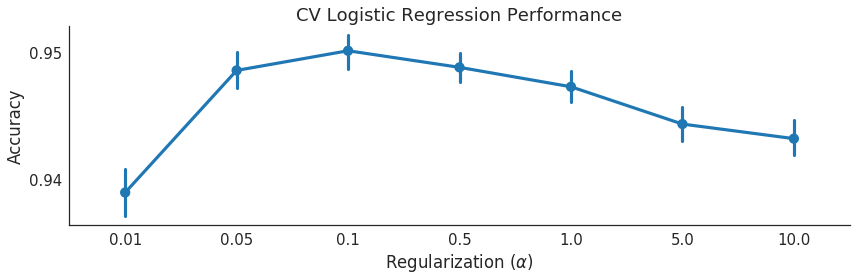

In [4]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Train logistic regression classifier.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define training parameters.
Cs = np.array([0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.])
train_size = 0.5
test_size = 0.5
n_splits = 50

## Initialize scikit-learn objects.
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, 
                             train_size=train_size, random_state=0)
lrcv = LogisticRegressionCV(Cs=Cs, cv=cv, penalty='l2', random_state=0)

## Fit cross-validated model.
fit = lrcv.fit(X,Y)
scores = DataFrame(fit.scores_[5], columns=fit.Cs_).melt()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
sns.pointplot('variable','value',data=scores, ax=ax)
ax.set(xlabel=r'Regularization ($\alpha$)', ylabel='Accuracy', yticks=[0.94,0.95],
       title='CV Logistic Regression Performance')
sns.despine()
plt.tight_layout()

As can be observed above, out-of-sample classification accuracy is highest with a moderate level of regularization ($\alpha = 0.1$). We will use this level of regularization in our example below. 

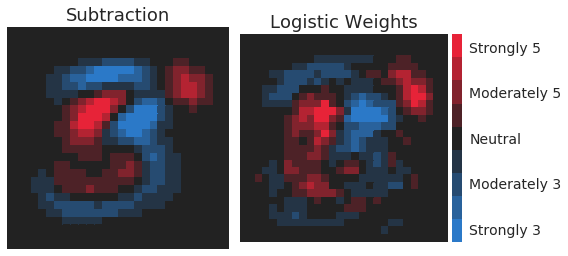

In [5]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Extract and prepare weights.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Extract weights.
w = np.median(fit.coefs_paths_[5][:,Cs==0.1,:-1], axis=0)
w = w.reshape(28,28)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(8,4))

## Plot subtraction.
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Subtraction')

## Plot logistic weights.
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(w, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='Logistic Weights')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

To reiterate, we train a logistic regression classifier with a moderate regularization ($\alpha = 0.1$). This classifier achieves 95% out-of-sample classification accuracy. In other words, this classifier is correct in predicting the digit class (i.e. 3 or 5) for 475/500 example images.  

Above we compare the weights of the logistic regression classifier (right) to the subtraction of the composite 3s and 5s (left). Simple visual inspection shows that the weights of the logistic regression classifier closely resemble the subtraction map. This provides strong evidence that logistic regression is equivalent to the relative differences algorithm. 

### c) Neural Network
We now move onto the neural network. Remember that a logistic-thresholded neural network differs from logistic regression only in the addition of a hidden layer(s). Though it is conceivable that the addition of hidden units may facilitate the learning of richer representations, the strong performance of the logistic regression classifier suggests that richer representations are unnecessary for this classification task. Thus it is likely the network will only learn the same impoverished representations. 

We test whether a neural network learns richer representations than relative differences by training a number of neural networks with one hidden layer of increasing size. If the networks are learning richer, more informative representations, classification performance should increase. If they are not, model performance should not improve from that of the logistic regression classifier.

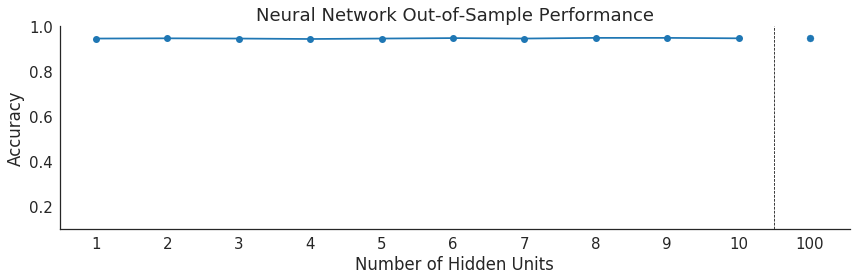

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Train neural networks.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define sizes.
sizes = np.arange(10) + 1
sizes = np.append(sizes, 100)

## Main loop.
scores = np.zeros_like(sizes, dtype=float)

## Split data.
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.5, test_size=0.5, 
                                                    stratify=Y, random_state=0)

for i, n in enumerate(sizes):

    ## Initialize neural network.
    nn = MLPClassifier((n), activation='logistic', solver='sgd', learning_rate='constant', 
                       alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

    ## Train.
    fit = nn.fit(X_train, y_train)
    
    ## Compute out-of-sample accuracy.
    scores[i] = fit.score(X_test, y_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot performance.
ax.plot(sizes[:-1], scores[:-1], marker='o')
ax.scatter(11, scores[-1], marker='o')
ax.vlines(10.5, 0.1, 1, linestyle='--', lw=0.75)
ax.set(xticks=np.arange(11)+1, xticklabels=np.append(np.arange(10)+1,100), 
       xlabel='Number of Hidden Units', ylim=(0.1,1), ylabel='Accuracy',
       title='Neural Network Out-of-Sample Performance')

sns.despine()
plt.tight_layout()

Irrespective of the number of hidden units, the neural network achieves out-of-sample classification performance comparable to the logistic regression classifier, i.e. approximately 95%. This is strongly suggestive that the neural networks have not learned richer representations. 

We now inspect the latent representation of the network, as stored in the weights connecting the input and hidden layers. 

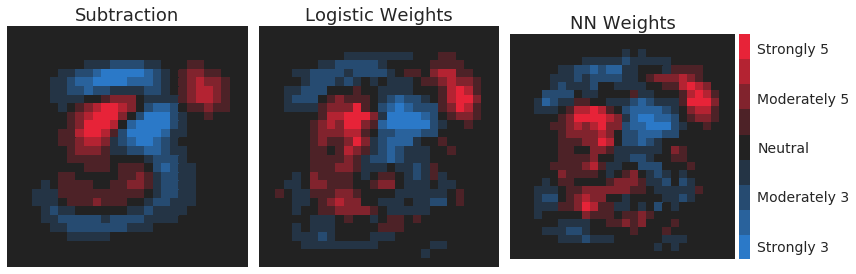

In [7]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Train neural network.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize neural network.
nn = MLPClassifier((1), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Extract weights.
input_weights = fit.coefs_[0]
input_weights = -1 * input_weights.reshape(28,28)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## Plot subtraction.
sns.heatmap(sub_img, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Subtraction')

## Plot logistic weights.
sns.heatmap(w, cmap=cmap, vmin=-0.4, vmax=0.4, square=True, cbar=False, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Logistic Weights')

## Plot neural network weights.
divider = make_axes_locatable(axes[-1])
cax = divider.append_axes("right", size="5%", pad=0.05)

sns.heatmap(input_weights, vmin=-0.4, vmax=0.4, square=True, cmap=cmap, ax=axes[-1], cbar_ax=cax)
axes[-1].set(xticks=[], yticks=[], title='NN Weights')

## Update colorbar.
cbar = axes[-1].collections[0].colorbar
cbar.set_ticks(np.linspace(-0.35,0.35,5))
cbar.ax.set_yticklabels(['Strongly 3', 'Moderately 3', 'Neutral', 'Moderately 5', 'Strongly 5'], fontsize=14);
plt.tight_layout()

As predicted, the input weights of the neural network (i.e. the weights between input layer and the 1 hidden unit) qualitatively resemble those of the logistic regression classifier. We can quantify the similarity between the logistic regression classifier and neural network by computing their angle using cosine similarity. By definition:

> Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. The cosine of 0 degrees is 1, and it is less than 1 for any other angle in the interval $[0,2\pi)$. It is thus a judgment of orientation and not magnitude: two vectors with the same orientation have a cosine similarity of 1, two vectors at 90 degrees have a similarity of 0, and two vectors diametrically opposed have a similarity of -1, independent of their magnitude. 

Given two vectors, cosine similarity is defined as:

$$ cos(\theta) = \frac{A \cdot B}{\lVert A \rVert \lVert B \rVert} =
    \frac{\sum_{i=1}^{n} A_i B_i}{\sqrt{\sum_{i=1}^n A_i^2}\sqrt{\sum_{i=1}^n B_i^2}}$$

In [8]:
from scipy.spatial.distance import cosine
print('Cosine similarity = %0.3f' %(1 - cosine(w.flatten(), input_weights.flatten())))

Cosine similarity = 0.931


This provides strong evidence that the neural network has achieved learning equivalent to the relative differences algorithm, i.e. impoverished representations sensitive only to relative differences and not spatial dependencies. 

This is perhaps a poor example of the sorts of representations neural networks can learn. We move onto a more challenging learning problem necessitating the learning of richer representations.

## Part 2: Classifying Digits 0-9

### a) The Challenge

Now let's reconsider the relative differences algorithm in light of a new problem: classifying digits 0-9. Intuition suggests that this is a much more challenging problem, one that is likely to confound the relative differences algorithm. Why? Because, across the set of digits, there are no pixels unique to a particular digit. For example, the pixels of the digit 8 are almost entirely overlapping with the superposition of the pixels of the digits 0 and 1. Similarly, the pixels of the digit 8 are overlapping with the superposition of the pixels of the digits 3 and 6. The same is true for the pixels of the digits 4, 7, and 5. (See below for illustration.) For the problem of classifying digits 0-9, relative differences are not enough; any successful learning algorithm will need to learn something about the spatial dependencies of pixels.

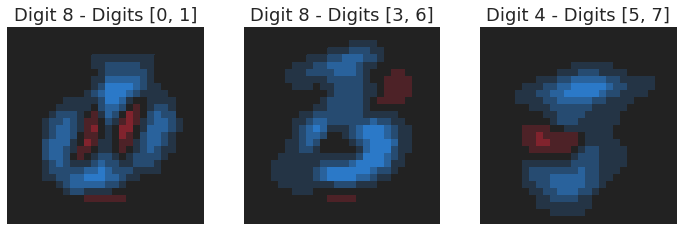

In [9]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute average images.
avg_images = np.array([data[target==i].mean(axis=0) for i in np.arange(10)])

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4))

## 8 - (0 + 1)
delta = avg_images[8] - avg_images[0] - avg_images[1]
sns.heatmap(delta.reshape(28,28), cmap=cmap, center=0, square=True, cbar=False, ax=axes[0])
axes[0].set(xticks=[], yticks=[], title='Digit 8 - Digits [0, 1]')

## 8 - (3 + 6)
delta = avg_images[8] - avg_images[3] - avg_images[6]
sns.heatmap(delta.reshape(28,28), cmap=cmap, center=0, square=True, cbar=False, ax=axes[1])
axes[1].set(xticks=[], yticks=[], title='Digit 8 - Digits [3, 6]')

## 4 - (7 + 5)
delta = avg_images[4] - avg_images[7] - avg_images[5]
sns.heatmap(delta.reshape(28,28), cmap=cmap, center=0, square=True, cbar=False, ax=axes[2])
axes[2].set(xticks=[], yticks=[], title='Digit 4 - Digits [5, 7]');

Another way to visualize this problem is to project all 10,000 images into a lower-dimensional space using principal components analysis (PCA). We should expect that if there are unique pixels for each digit, then PCA will be able to cluster digits into non-overlapping regions of a two-dimensional pixel sub-space.

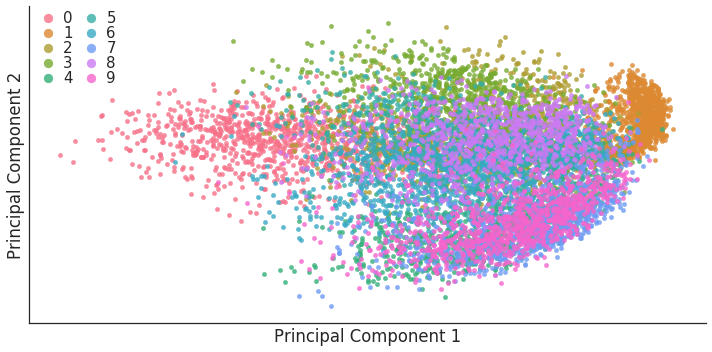

In [10]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Perform PCA.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Compute principal components.
U, S, Vt = np.linalg.svd( np.cov(data.T) )

## De-mean data.
X0 = np.apply_along_axis(lambda arr: arr - arr.mean(), 0, data)

## Project onto first two principal components.
X0_proj = X0 @ U[:,:2]

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(10,5))

## Iteratively plot.
for i, color in enumerate(sns.husl_palette(n_colors=10).as_hex()):
    
    ax.scatter(*X0_proj[target==i].T, s=20, color=color, label=i, alpha=0.8)
    
## Add info.
ax.set(xticks=[], xlabel='Principal Component 1', yticks=[], ylabel='Principal Component 2')
ax.legend(loc=2, ncol=2, markerscale=2, borderpad=-0.25, labelspacing=0, 
          columnspacing=0.25, handletextpad=0)

sns.despine()
plt.tight_layout()

When projected into a lower dimensional space, the digit classes are largely overlapping. With the exception of (maybe) 0s (salmon) and 1s (orange), most clusters of digits are overlaid on top of one another. This provides further evidence that simple learning strategies are unlikely to succeed. Indeed, richer representations are likely needed in order to solve this classification problem.

### b) Neural Network
Below we fit and test the performance of uniformly-connected, logistic-thresholded neural networks with one hidden layer and an increasing number of hidden units. Specifically, we test networks with 1-10 hidden units, in addition to 100 hidden units to measure asymptotic performance.

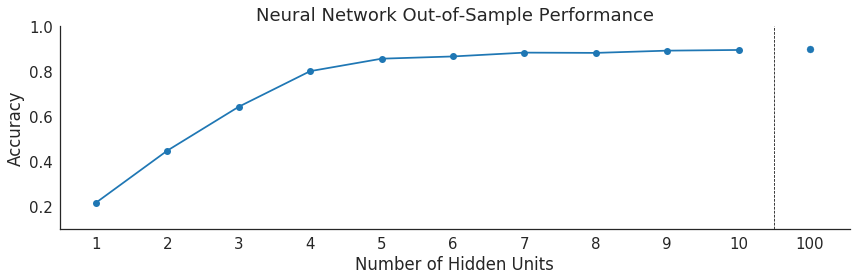

In [11]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Train neural networks.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define sizes.
sizes = np.arange(10) + 1
sizes = np.append(sizes, 100)

## Split data.
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.5, test_size=0.5, 
                                                    stratify=target, random_state=0)

## Main loop.
scores = np.zeros_like(sizes, dtype=float)

for i, n in enumerate(sizes):

    ## Initialize neural network.
    nn = MLPClassifier((n), activation='logistic', solver='sgd', learning_rate='constant', 
                       alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

    ## Train.
    fit = nn.fit(X_train, y_train)
    
    ## Compute out-of-sample accuracy.
    scores[i] = fit.score(X_test, y_test)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plot.
ax.plot(sizes[:-1], scores[:-1], marker='o')
ax.scatter(11, scores[-1], marker='o')
ax.vlines(10.5, 0.1, 1, linestyle='--', lw=0.75)
ax.set(xticks=np.arange(11)+1, xticklabels=np.append(np.arange(10)+1,100), 
       xlabel='Number of Hidden Units', ylim=(0.1,1), ylabel='Accuracy',
       title='Neural Network Out-of-Sample Performance')

sns.despine()
plt.tight_layout()

Increasing the number of units in the single hidden layer dramatically increases performance at first (from 1 to 5 units). Out-of-sample classification performance rises precipitously from approximately 20% (1 hidden unit) to over 80% (5 total units), but quickly slows following. By 100 hidden units, classification accuracy has reached 90%. It is worth noting that even the 100 hidden unit network does not achieve performance as strong as the logistic regression classifier in the two-digit classification problem (i.e. 3 vs. 5). This highlights how much more challenging the 10-digit classification problem is than the 2-digit classification problem!

The increasing performance suggests that the networks of increasing hidden units have learned richer latent representations. To examine these latent representations, we examine the weights of a network with five hidden units. We select this network as it is closest to the "elbow" or bend of the performance curve (i.e. where performance growth slows). 

### c) Latent Representations
To understand the latent representations learned by the neural network, we first visualize the weights connecting the input and hidden layers ($W_{h,i}$).

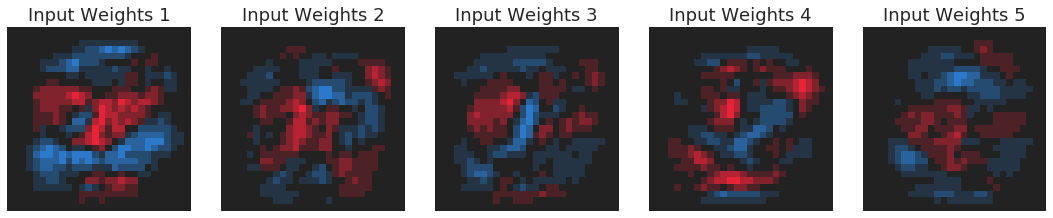

In [12]:
## Initialize neural network.
nn = MLPClassifier((5), activation='logistic', solver='sgd', learning_rate='constant', 
                   alpha=1, max_iter=1000, learning_rate_init=0.1, momentum=0, random_state=0)

## Train.
fit = nn.fit(X_train, y_train)

## Extract weights.
input_weights = fit.coefs_[0].T

## Initialize canvas.
fig, axes = plt.subplots(1,5,figsize=(15,3))

for ax, w, i in zip(axes.flatten(), input_weights, np.arange(5)+1):
        
    ## Plot image.
    sns.heatmap(w.reshape(28,28), cmap=cmap, center=0, square=True, cbar=False, ax=ax)
    ax.set(xticks=[], yticks=[], title='Input Weights %s' %i)
    
plt.tight_layout()

What should be immediately apparent in inspecting the input-to-hidden weights ($W_{h,i}$) is that they are no longer recognizable as the relative differences of any pairs of digits (as they were in discriminating between the digits 3 and 5). In other words, the network is not simply learning which pixels are most representative of each digit. 

To make sense of these representations, we next visualize the weights connecting the hidden and output layers ($W_{o,h}$). 

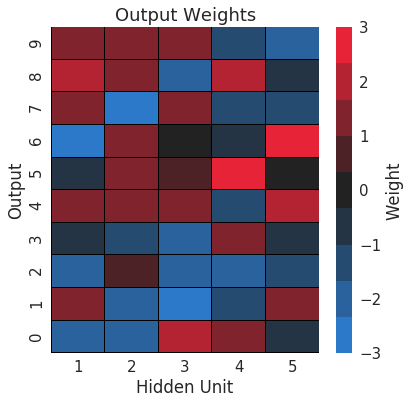

In [13]:
## Extract output weights.
output_weights = fit.coefs_[1].T

## Plot.
fig, ax = plt.subplots(1,1,figsize=(6,6))

sns.heatmap(output_weights, cmap=cmap, vmin=-3, vmax=3, linewidths=0.05, linecolor='k',
            xticklabels=np.arange(5)+1, cbar_kws=dict(label='Weight'), ax=ax)
ax.set(xlabel='Hidden Unit', ylabel='Output', title='Output Weights')
ax.invert_yaxis()

To reiterate, the plot above visualizes the weights connecting the hidden layer to the output layer ($W_{o,h}$). These weights are immediately interpretable: they dictate the patterns of activation necessary from the hidden units for the network to predict a particular digit, 0-9. For example, for the network to predict the digit 9, the first three hidden units must output positive activation, but not the remaining hidden units. By contrast, for the network to predict the digit 0, the third and fourth hidden units must output positive activation, but not the first, second, and fifth. 

With this in mind, it becomes clear that the weights connecting the input and hidden layers cannot be interpreted independently; indeed, the hidden-output weights suggest that the input-hidden unit weights are structured to generate particular combinations of hidden unit activation. This suggests that the latent representations learned by the network are likely combinatoric (i.e. can be combined in different patterns to produce different meaningful patterns). 

To demonstrate this, we can run the network "in reverse". To do so, we project a particular pattern of output activation back through the network from the output layer to the input layer via the hidden units. The resulting activation measured at the input layer represents the summation of the network activity projected through the input-hidden weights ($W_{h,i}$), which is equivalent to the combination of the latent representations stored in the input-hidden weights. Below we visualize the resulting representations when projecting back through the network output activations corresponding to the digits 2, 7, and 8. 

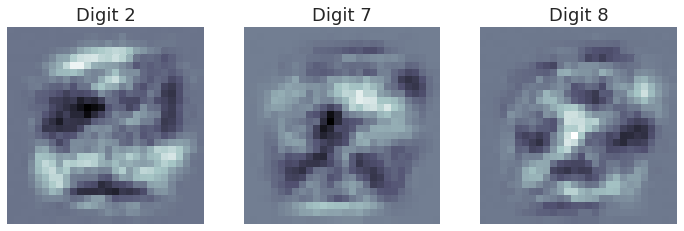

In [14]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Plotting.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4)) 
zscore = lambda arr: (arr - arr.mean()) / arr.std()

patterns = []
for ax, i in zip(axes, [2, 7, 8]):

    ## Define hidden unit activation.
    activation = output_weights[i]

    ## Project onto input weights.
    pattern = activation @ input_weights

    ## Normalize pattern.
    pattern = zscore(pattern)
    patterns.append(pattern)
    
    ## Plot.
    sns.heatmap(pattern.reshape(28,28), cmap='bone', center=0, cbar=False, square=True, ax=ax)
    ax.set(xticks=[], yticks=[], title='Digit %s' %i)

Though imperfect, the images above look very similar to the corresponding digits of the chosen output patterns! When we project the output activation corresponding to the digit 2 back through the network, the resulting representation resembles the digit 2. (So too for the output activation patterns corresponding to the digits 7 and 8.) This demonstrates that the latent representations stored in the weights connecting the input and hidden layers encode image features whose combinations match the shapes of particular digits. Put another way, the network has learned rich, combinatoric representations in the form of the spatial patterns that together comprise digit shapes. 

To demonstrate our interpretation of the representations above are not merely wishful thinking, we again use cosine similarity to identify the digit most similar to the patterns above. 

In [15]:
digits = np.arange(10)

for target, pattern in zip([2,7,8], patterns):
    
    ## Compute cosine similarities.
    similarities = [1 - cosine(avg_img, pattern) for avg_img in avg_images]

    ## Find most similar.
    print('Digit most similar to "%s-pattern": %0.0f' %(target, digits[np.argmax(similarities)]))

Digit most similar to "2-pattern": 2
Digit most similar to "7-pattern": 7
Digit most similar to "8-pattern": 8


To summarize, to solve the much harder problem of digit classification with 10 digits, the neural network has learned richer representations of the constitutive elements of digit shapes, whose combinations give rise to particular digits.